In [1]:
import json 
path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_hierarchical_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10.json"


with open(path) as f:
    all_results = json.load(f)

print(all_results.keys())
another_path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_hierarchical_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10_2_10_rerun.json"
with open(another_path) as f:
    all_results_2 = json.load(f)

# # combine the results
for key in all_results_2.keys():
    for key2 in all_results_2[key].keys():
        all_results[key][key2] = all_results_2[key][key2]

all_results_3_path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_hierarchical_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10_x_learner.json"
with open(all_results_3_path) as f:
    all_results_3 = json.load(f)

# add the x-learner results
for key in all_results_3.keys():
    for key2 in all_results_3[key].keys():
        all_results[key][key2] = all_results_3[key][key2]

# all_results_4_path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_hierarchical_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10_all_baselines.json"

# with open(all_results_4_path) as f:
#     all_results_4 = json.load(f)

# # add the x-learner results
# for key in all_results_4.keys():
#     for key2 in all_results_4[key].keys():
#         all_results[key][key2] = all_results_4[key][key2]
# all_results.keys()

# # save the combined results
# with open(path, 'w') as f:
#     json.dump(all_results, f, indent=4)

dict_keys(['2', '3', '4', '5', '6', '7', '8', '9', '10'])


In [2]:
all_results

{'2': {'Baseline_train': [3.472734218097782, 0.9678652398432873],
  'Baseline_test': [731.8853747089313, -4.8716196196526145],
  'Catenets_train': [28.07358349660682, 0.740222598175952],
  'Catenets_test': [2883.8282545559478, -22.135784843211763],
  'End_to_End_known_cov_train': [47.35882798454962, 0.5617676208402352],
  'End_to_End_known_cov_test': [81.0500166365352, 0.3497685781116847],
  'End_to_End_unknown_cov_train': [12.381044674177401, 0.8854326659895764],
  'End_to_End_unknown_cov_test': [6.072527962431127e+16, -487174297468094.1],
  'Sequential_known_cov_train': [5.517312470407282, 0.948945844452417],
  'Sequential_known_cov_test': [4.869208998156654, 0.9609363104200082],
  'Sequential_unknown_cov_train': [7.525437257032559, 0.9303637692545343],
  'Sequential_unknown_cov_test': [51.86715472293382, 0.5838908471045042],
  'XLearner_train': [5.846569988688401, 0.9458990776354753],
  'XLearner_test': [142.1093235247493, -0.14008548466393678]},
 '3': {'Baseline_train': [22.2969421

In [2]:

# Insights 
# High-level model does worse when the covariates are shared across modules surprisingly

In [3]:
# # Hypotheses to test
# # 1. Each component output is a quadratic function of the input features.
# # 2. Plot final output vs input features.

# # Hypothesis 1
# # plot 1
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(style="whitegrid")
# sns.set_context("talk")
# max_modules = args.num_modules
# fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
# for i in range(max_modules):
#     sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
#     ax[i].set_title(f"Module {i}")

# fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
# for i in range(max_modules):
#     sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
#     ax[i].set_title(f"Module {i}")

# # Have a 3D plot for two features and one output
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



In [12]:
all_results['2'].keys()

dict_keys(['Baseline_train', 'Baseline_test', 'Catenets_train', 'Catenets_test', 'End_to_End_known_cov_train', 'End_to_End_known_cov_test', 'End_to_End_unknown_cov_train', 'End_to_End_unknown_cov_test', 'Sequential_known_cov_train', 'Sequential_known_cov_test', 'Sequential_unknown_cov_train', 'Sequential_unknown_cov_test', 'XLearner_train', 'XLearner_test', 'TLearner_train', 'TLearner_test', 'SLearner_train', 'SLearner_test', 'RandomForest_train', 'RandomForest_test', 'NonParamDML_train', 'NonParamDML_test'])

[731.8853747089313, 1039.0593494373422, 819.8218554654787, 178.97539162146975, 185.199819091347, 154.27800892254697, 335.5134628894814, 88.33680138271865, 2.797701347476567]
[ 3  4  5  6  7  8  9 10]
[4.869208998156654, 2.6328475315704054, 1.5207470298794101, 1.2278046904170694, 0.4836155566620965, 0.09099181883809088, 0.20188969619307554, 0.050142220376395534, 0.1067366626116597]
[ 3  4  5  6  7  8  9 10]
[51.86715472293382, 7.0902259340617, 3.298521211273407, 2.3067932318082316, 1.3129247086762907, 2.146457775280569, 0.3856813631957183, 0.6747717157464025, 0.12335560051714156]
[ 3  4  5  6  7  8  9 10]
[81.0500166365352, 15.621641246092908, 3.598111155447756, 1.9111766894549422, 1.1631731653792177, 1.0624217171000372, 1.016727967855696, 0.7229260068381292, 0.955942826129365]
[ 3  4  5  6  7  8  9 10]
[6.072527962431127e+16, 28.74812773371282, 12.513380027674277, 4.225511719117108, 3.2221638245683897, 2.3924460089616315, 1.2402476637128321, 1.2719600650466807, 1.1366747091047327]
[ 3 

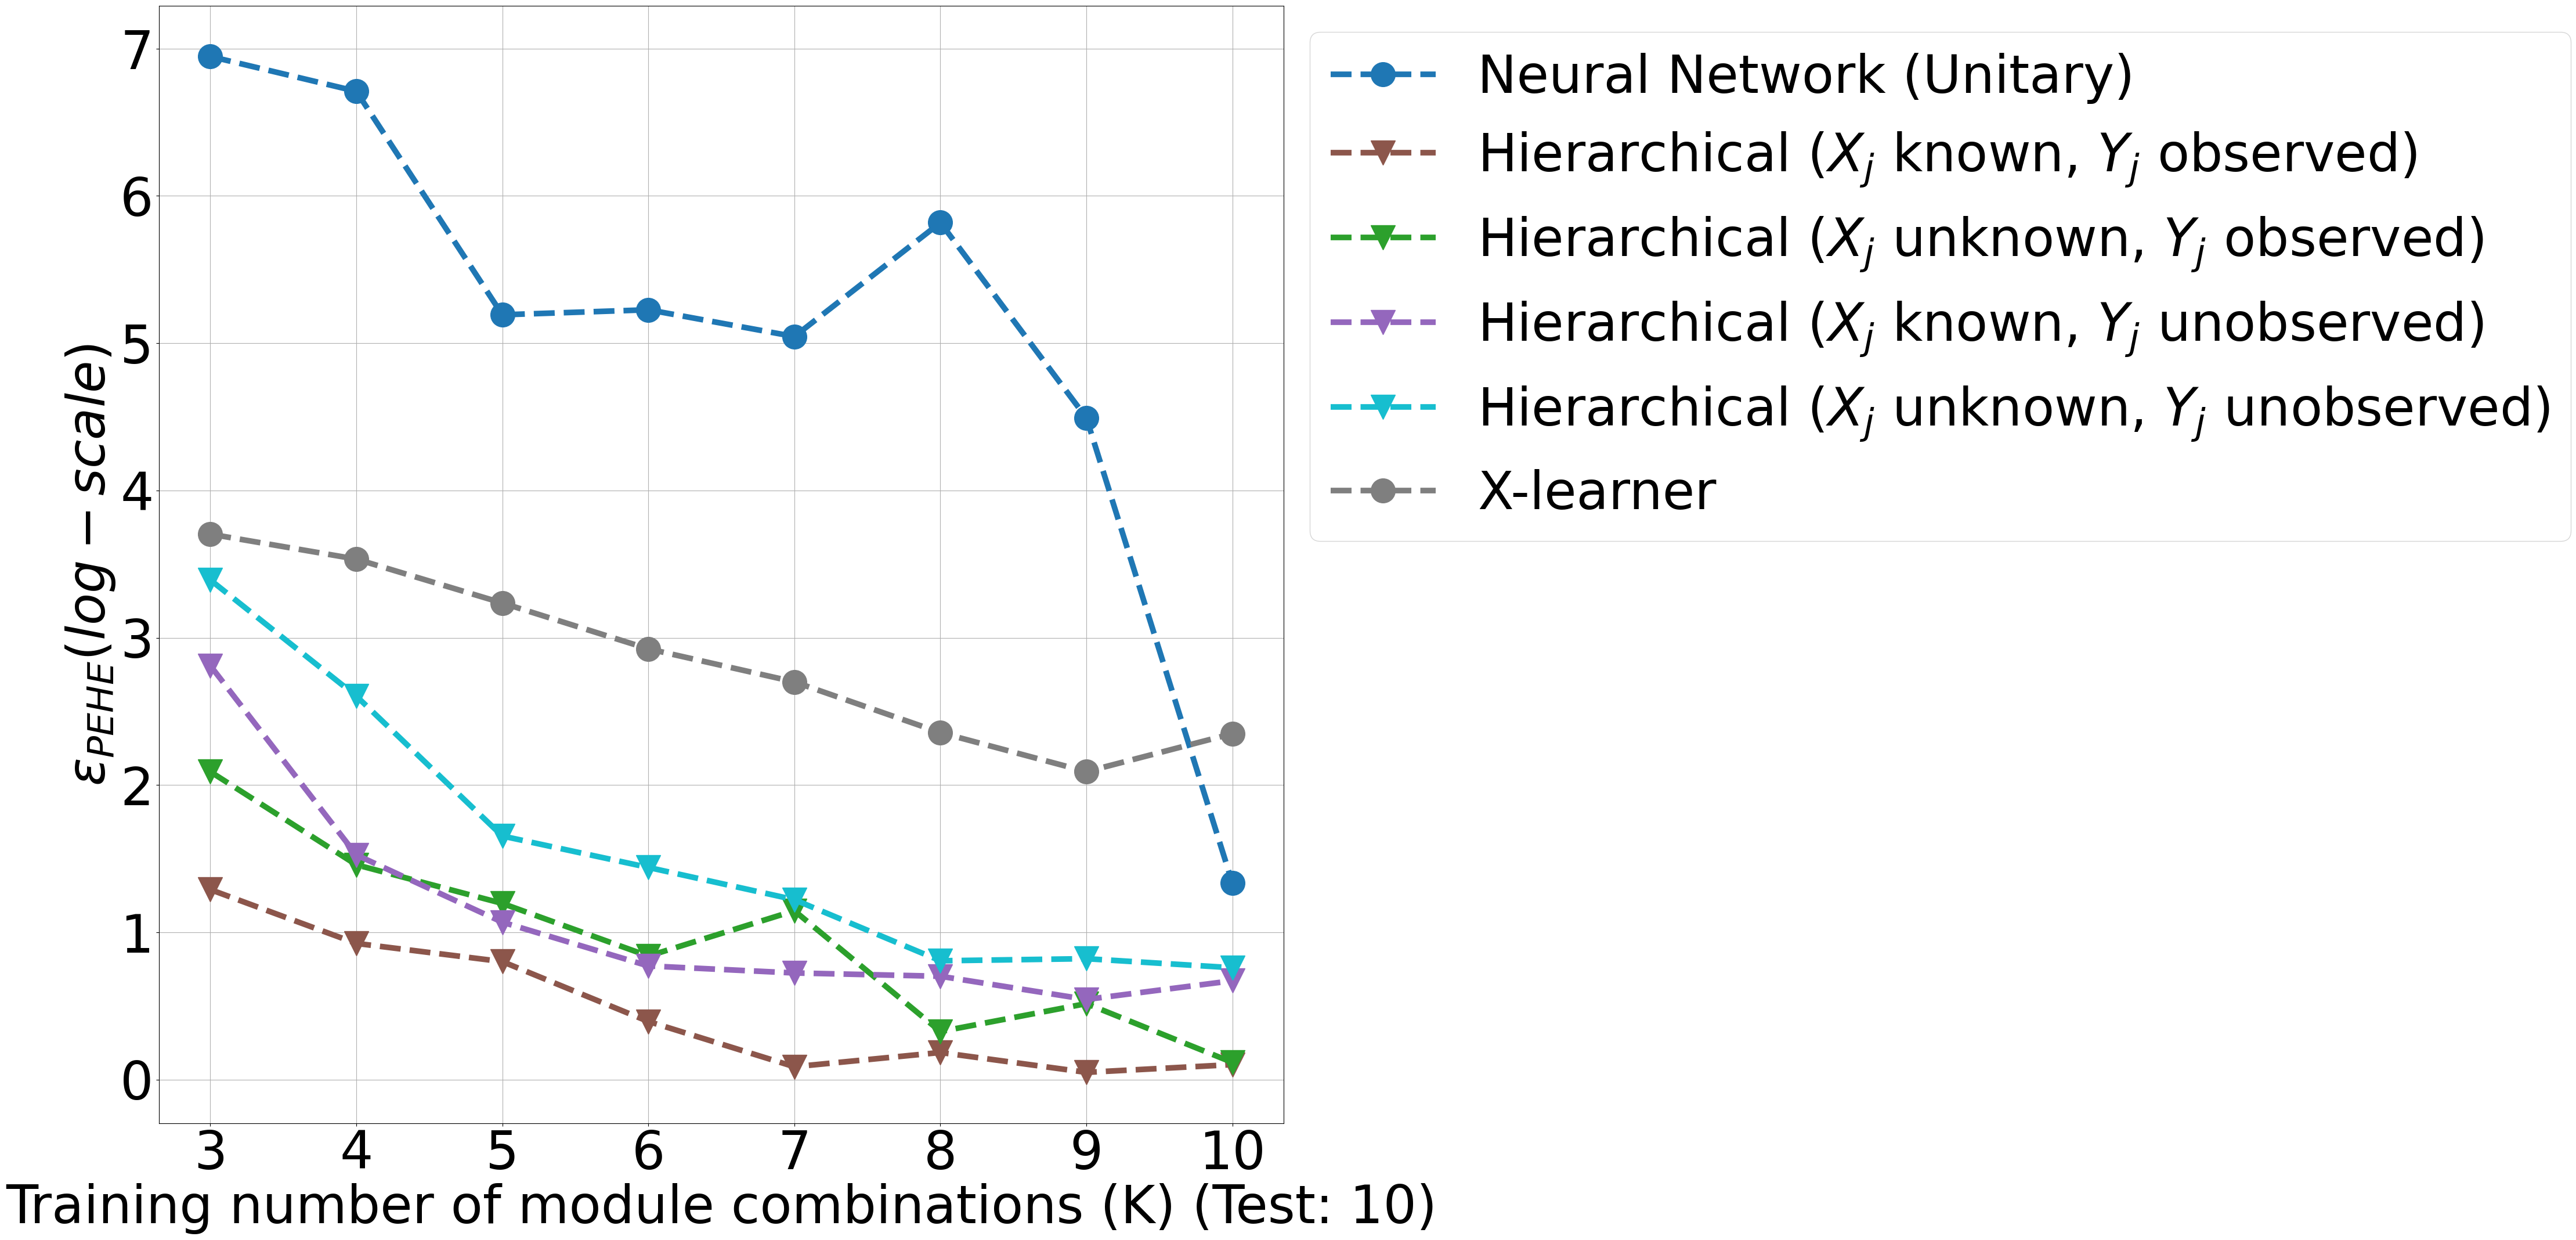

In [3]:
# Colors for each model
from matplotlib import pyplot as plt
import numpy as np
exp = "CG"
args = {}
args["number_of_modules"] = 5
import math
import os

from matplotlib import pyplot as plt
from matplotlib import ticker

# ... (previous code remains the same) ...


font_size = 65
plt.rcParams.update({'font.size': font_size})
plt.rcParams.update({'legend.fontsize': font_size})
plt.rcParams.update({'axes.labelsize': font_size})
plt.rcParams.update({'axes.titlesize': font_size})
markersize = 30


# "neural_network": '#1f77b4',
#                 "recursive_single_outcome": '#ff7f0e',
#                 "recursive_all_outcomes": '#2ca02c',
#                 "modular_single_outcome": '#17becf',
#                 "modular_all_outcomes": '#9467bd',
#                 "random_forest_additive": '#8c564b',
#                 "neural_network_additive": '#8c564b',
#                 "x_learner": '#7f7f7f',
#                 "s_learner": '#bcbd22',
#                 "t_learner":  '#17becf',
#                 "random_forest": '#e377c2',
#                 "non_param_DML": '#d62728',
#                 "snet1": '#8c564b',
#                 "snet2": '#d62728',
#                 "tnet": '#bcbd22'

colors = {
    'Baseline': '#1f77b4',
    'MoE': 'green',
    'Catenets': '#bcbd22',
    'Sequential_unknown_cov': '#2ca02c',
    'End_to_End_unknown_cov': '#17becf',
    'Sequential_known_cov': '#8c564b',
    'End_to_End_known_cov': '#9467bd',
    'XLearner': '#7f7f7f',
    'TLearner': '#17becf',
    'SLearner': '#bcbd22',
    'RandomForest': '#8c564b',
    'NonParamDML': '#d62728',
}
linewidth = 7


labels = {'Sequential_unknown_cov': r'Hierarchical ($X_j$ unknown, $Y_j$ observed)', 'Sequential_known_cov': r'Hierarchical ($X_j$ known, $Y_j$ observed)', 'End_to_End_unknown_cov': r'Hierarchical ($X_j$ unknown, $Y_j$ unobserved)', 'End_to_End_known_cov': r'Hierarchical ($X_j$ known, $Y_j$ unobserved)', 'Baseline': 'Neural Network (Unitary)','XLearner': 'X-learner', 'RandomForest': 'Random Forest', 'NonParamDML': 'NonParamDML', 'SLearner': 'S-learner', 'TLearner': 'T-learner'}
markers = {'Sequential_unknown_cov': 'v', 'Sequential_known_cov': 'v', 'End_to_End_unknown_cov': 'v', 'End_to_End_known_cov': 'v', 'Catenets': 'o', 'Baseline': 'o', 'XLearner': 'o', 'RandomForest': 'o', 'NonParamDML': 'o', 'SLearner': 'o', 'TLearner': 'o'}
fig, (ax1) = plt.subplots(1, 1, figsize=(25, 25))
# Function to plot performance
def plot_performance(metric, metric_name, data_type, axis):
    # fig1, ax1 = plt.subplots(figsize=(25, 20))
    
    x = [2, 3, 4, 5, 6, 7, 8, 9,10]
    # convert string to float
    x = [int(i) for i in x]
    # remove key 5
    # x = [i for i in x if i != 5]
   
    
    for model in ['Baseline', 'Sequential_known_cov', 'Sequential_unknown_cov', 'End_to_End_known_cov', 'End_to_End_unknown_cov', 'XLearner']:
        y = [all_results[str(key)][f'{model}_{data_type}'][metric] for key in x]
        print(y)
        # replace negative values with 0
        y = [0 if i < 0 else i for i in y][1:]
        # log scale for PEHE
        if metric_name == 'PEHE':
            # y = [math.sqrt(i) for i in y]
            y = [math.log(i+1) for i in y]
        # if exp == "noise":
        x_plot = np.array(x)[1:]
        # else:
        #     x_plot = 1-np.array(x)
        #     print(x_plot)
        #     x_plot = [i*5 for i in x_plot]
        print(x_plot)


        label_name = r'{}'.format(labels[model])
        axis.plot(x_plot, y, color=colors[model], label=label_name,
                 linestyle='-' if data_type == 'train' else '--', marker=markers[model], markersize=markersize, linewidth=linewidth)

        
    
    plt.xlabel('Training number of module combinations (K) (Test: 10)')
    if metric_name == 'PEHE':
         metric_title = r'$\epsilon_{PEHE} (log-scale)$'
    elif metric_name == 'R^2':
        metric_title = r'$R^2$'
    axis.set_ylabel(metric_title)
    # y-axis in log scale
    # plt.yscale('log')
    
    # set x-axis ticks as x_plot
    axis.set_xticks(x_plot)
    
    # plt.title(f'{metric_title} Performance ({data_type.capitalize()})')
    # legend outside plot
    
# Plot PEHE for train and test
# plot_performance(0, 'PEHE', 'train')
plot_performance(0, 'PEHE', 'test', ax1)

# # # Plot R^2 for train and test
# # plot_performance(1, 'R^2', 'train')
# plot_performance(1, 'R^2', 'test', ax2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=font_size)
    
    
plt.grid(True)

plot_dir = "clear_plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plt.savefig("clear_plots/prior_knowledge_sequential_all.pdf", bbox_inches='tight')



In [6]:
import json

all_results_parallel_path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_parallel_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10.json"
with open(all_results_parallel_path) as f:
    all_results_parallel = json.load(f)
all_results_parallel.keys()

another_path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_parallel_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10_x_learner.json"
with open(another_path) as f:
    all_results_parallel_2 = json.load(f)

# combine the results
for key in all_results_parallel_2.keys():
    for key2 in all_results_parallel_2[key].keys():
        all_results_parallel[key][key2] = all_results_parallel_2[key][key2]

moe_rerun_path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_parallel_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10_MoE_rerun.json"
with open(moe_rerun_path) as f:
    moe_rerun = json.load(f)

# combine the results
for key in moe_rerun.keys():
    for key2 in moe_rerun[key].keys():
        all_results_parallel[key][key2] = moe_rerun[key][key2]

# another_parallel_results = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_parallel_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10_all_baselines.json"

# with open(another_parallel_results) as f:
#     another_parallel_results = json.load(f)

# # combine the results
# for key in another_parallel_results.keys():
#     for key2 in another_parallel_results[key].keys():
#         all_results_parallel[key][key2] = another_parallel_results[key][key2]

# another_path = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_parallel_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_CG_number_of_modules_10_4_10.json"
# with open(another_path) as f:
#     all_results_parallel_2 = json.load(f)

# # combine the results
# for key in all_results_parallel_2.keys():
#     all_results_parallel[key] = all_results_parallel_2[key]

[-2.7630931909760834, 0.600098113747342, 0.9353563839267935, 0.9304830819050272, 0.9702013620327361, 0.9934506390964328, 0.9885500636148459, 0.9902057664981488, 0.9938641860700262]
[ 2  3  4  5  6  7  8  9 10]
[0.7745469106261457, 0.9611699881324552, 0.9878910936751756, 0.9855276210389465, 0.9956866717381753, 0.9954960854281117, 0.9979310710256952, 0.9963839434909907, 0.9992707712584371]
[ 2  3  4  5  6  7  8  9 10]
[0.9996607954895889, 0.9991443351799968, 0.9990815509865922, 0.9997131396037185, 0.9997358485376374, 0.9998258895020394, 0.999853424742653, 0.9999377076568642, 0.9994437648162667]
[ 2  3  4  5  6  7  8  9 10]
[0.6916206704008991, 0.8812064676654736, 0.991476696827163, 0.9960904674804039, 0.9992690519398405, 0.9992512377526918, 0.9994891287639739, 0.9997775056365803, 0.9997289047039961]
[ 2  3  4  5  6  7  8  9 10]
[0.9902266692238441, 0.9960496052278045, 0.9980197877015377, 0.9954229271902582, 0.9984710487935857, 0.9982068444749987, 0.9966760488552145, 0.9990517369476741, 0

KeyError: 'RandomForest_test'

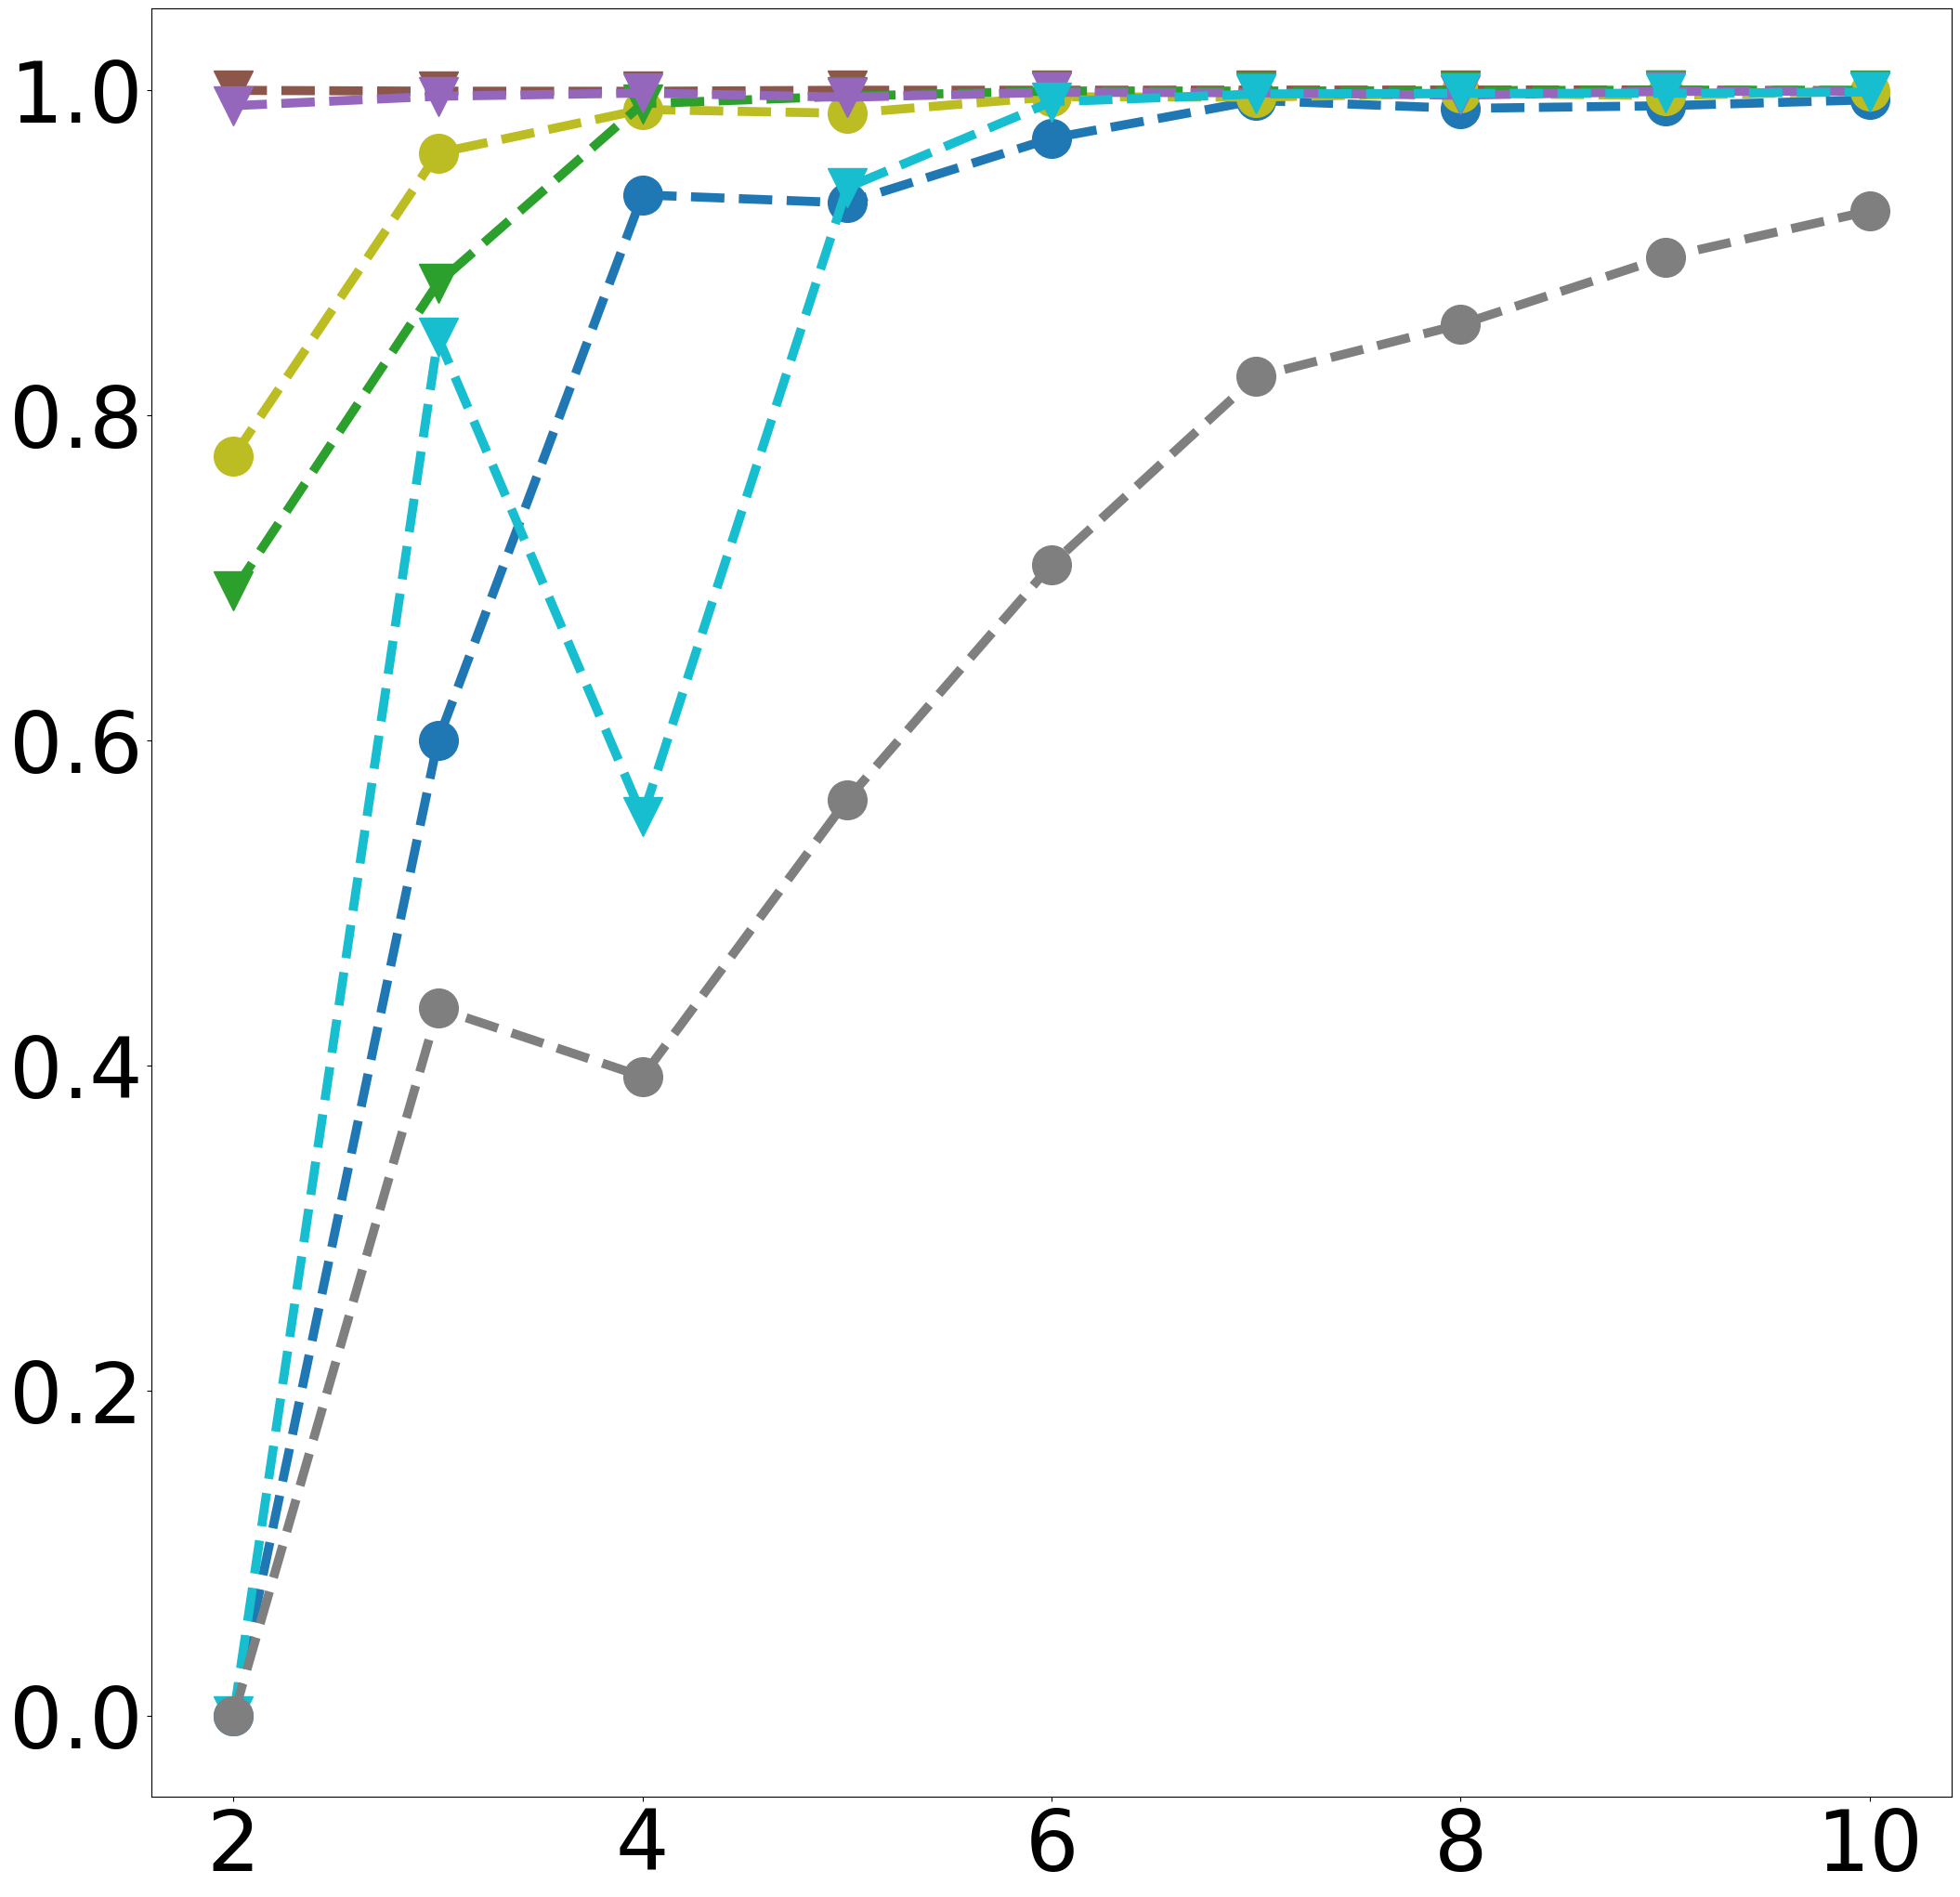

In [ ]:
colors_parallel = {
    'Baseline': '#1f77b4',
    'MoE': '#17becf',
    'MoEknownCov': '#9467bd',
    'Catenets': '#bcbd22',
    'Additive_unknown_cov': '#2ca02c',
    'Additive_known_cov': '#8c564b',
    'XLearner': '#7f7f7f',
    'TLearner': '#17becf',
    'SLearner': '#bcbd22',
    'RandomForest': '#8c564b',
    'NonParamDML': '#d62728',
    
    
}
linewidth = 7


labels_parallel = {'Additive_unknown_cov': r'Parallel ($X_j$ unknown, $Y_j$ observed)', 'Additive_known_cov': r'Parallel ($X_j$ known, $Y_j$ observed)', 'MoE': r'Parallel ($X_j$ unknown, $Y_j$ unobserved)', 'MoEknownCov': r'Parallel ($X_j$ known, $Y_j$ unobserved)', 'Catenets': 'TNet (Unitary)', 'Baseline': 'Neural Network (Unitary)', 'XLearner': 'X-learner', 'RandomForest': 'Random Forest', 'NonParamDML': 'NonParamDML', 'SLearner': 'S-learner', 'TLearner': 'T-learner'}
markers_parallel = {'Additive_unknown_cov': 'v', 'Additive_known_cov': 'v', 'MoE': 'v', 'MoEknownCov': 'v', 'Catenets': 'o', 'Baseline': 'o', 'XLearner': 'o', 'RandomForest': 'o', 'NonParamDML': 'o', 'SLearner': 'o', 'TLearner': 'o'}
fig, (ax1) = plt.subplots(1, 1, figsize=(25, 25))
# Function to plot performance
def plot_performance_parallel(metric, metric_name, data_type, axis):
    # fig1, ax1 = plt.subplots(figsize=(25, 20))
    
    x = list(all_results_parallel.keys())
    # convert string to float
    x = [int(i) for i in x]
    # remove key 5
    # x = [i for i in x if i != 5]
   
    
    for model in ['Baseline', 'Catenets', 'Additive_known_cov', 'Additive_unknown_cov',  'MoEknownCov',  'MoE', 'XLearner', 'RandomForest', 'NonParamDML', 'SLearner', 'TLearner']:
        y = [all_results_parallel[str(key)][f'{model}_{data_type}'][metric] for key in x]
        print(y)
        # replace negative values with 0
        y = [0 if i < 0 else i for i in y]
        # log scale for PEHE
        if metric_name == 'PEHE':
            # y = [math.sqrt(i) for i in y]
            y = [math.log(i+1) for i in y]
        # if exp == "noise":
        x_plot = np.array(x)
        # else:
        #     x_plot = 1-np.array(x)
        #     print(x_plot)
        #     x_plot = [i*5 for i in x_plot]
        print(x_plot)


        label_name = r'{}'.format(labels_parallel[model])
        axis.plot(x_plot, y, color=colors_parallel[model], label=label_name,
                 linestyle='-' if data_type == 'train' else '--', marker=markers_parallel[model], markersize=markersize, linewidth=linewidth)

        
    
    plt.xlabel('Training number of module combinations (K) (Test: 10)')
    if metric_name == 'PEHE':
        metric_title = r'$PEHE (log-scale)$'
    elif metric_name == 'R^2':
        metric_title = r'$R^2$'
    axis.set_ylabel(metric_title)
    # y-axis in log scale
    # plt.yscale('log')
    
    # set x-axis ticks as x_plot
    axis.set_xticks(x_plot)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=font_size)
plot_performance_parallel(1, 'R^2', 'test', ax1)

In [37]:
all_results_parallel['2'].keys()

dict_keys(['Baseline_train', 'Baseline_test', 'MoE_train', 'MoE_test', 'MoEknownCov_train', 'MoEknownCov_test', 'Catenets_train', 'Catenets_test', 'Additive_known_cov_train', 'Additive_known_cov_test', 'Module_known_cov_PEHE_decomposition_test', 'Module_PEHE_known_cov_decomposition_train', 'Additive_unknown_cov_train', 'Additive_unknown_cov_test', 'Module_unknown_cov_PEHE_decomposition_test', 'Module_PEHE_unknown_cov_decomposition_train', 'XLearner_train', 'XLearner_test'])

8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
[1.047290745916791, 1.8601924466105209, 0.5481990567637651, 0.08611770993274104, 0.030644242031428872, 0.026191412524467383, 0.025745048548764724, 0.01660877382897259]
8 8
8 8
8 8
8 8


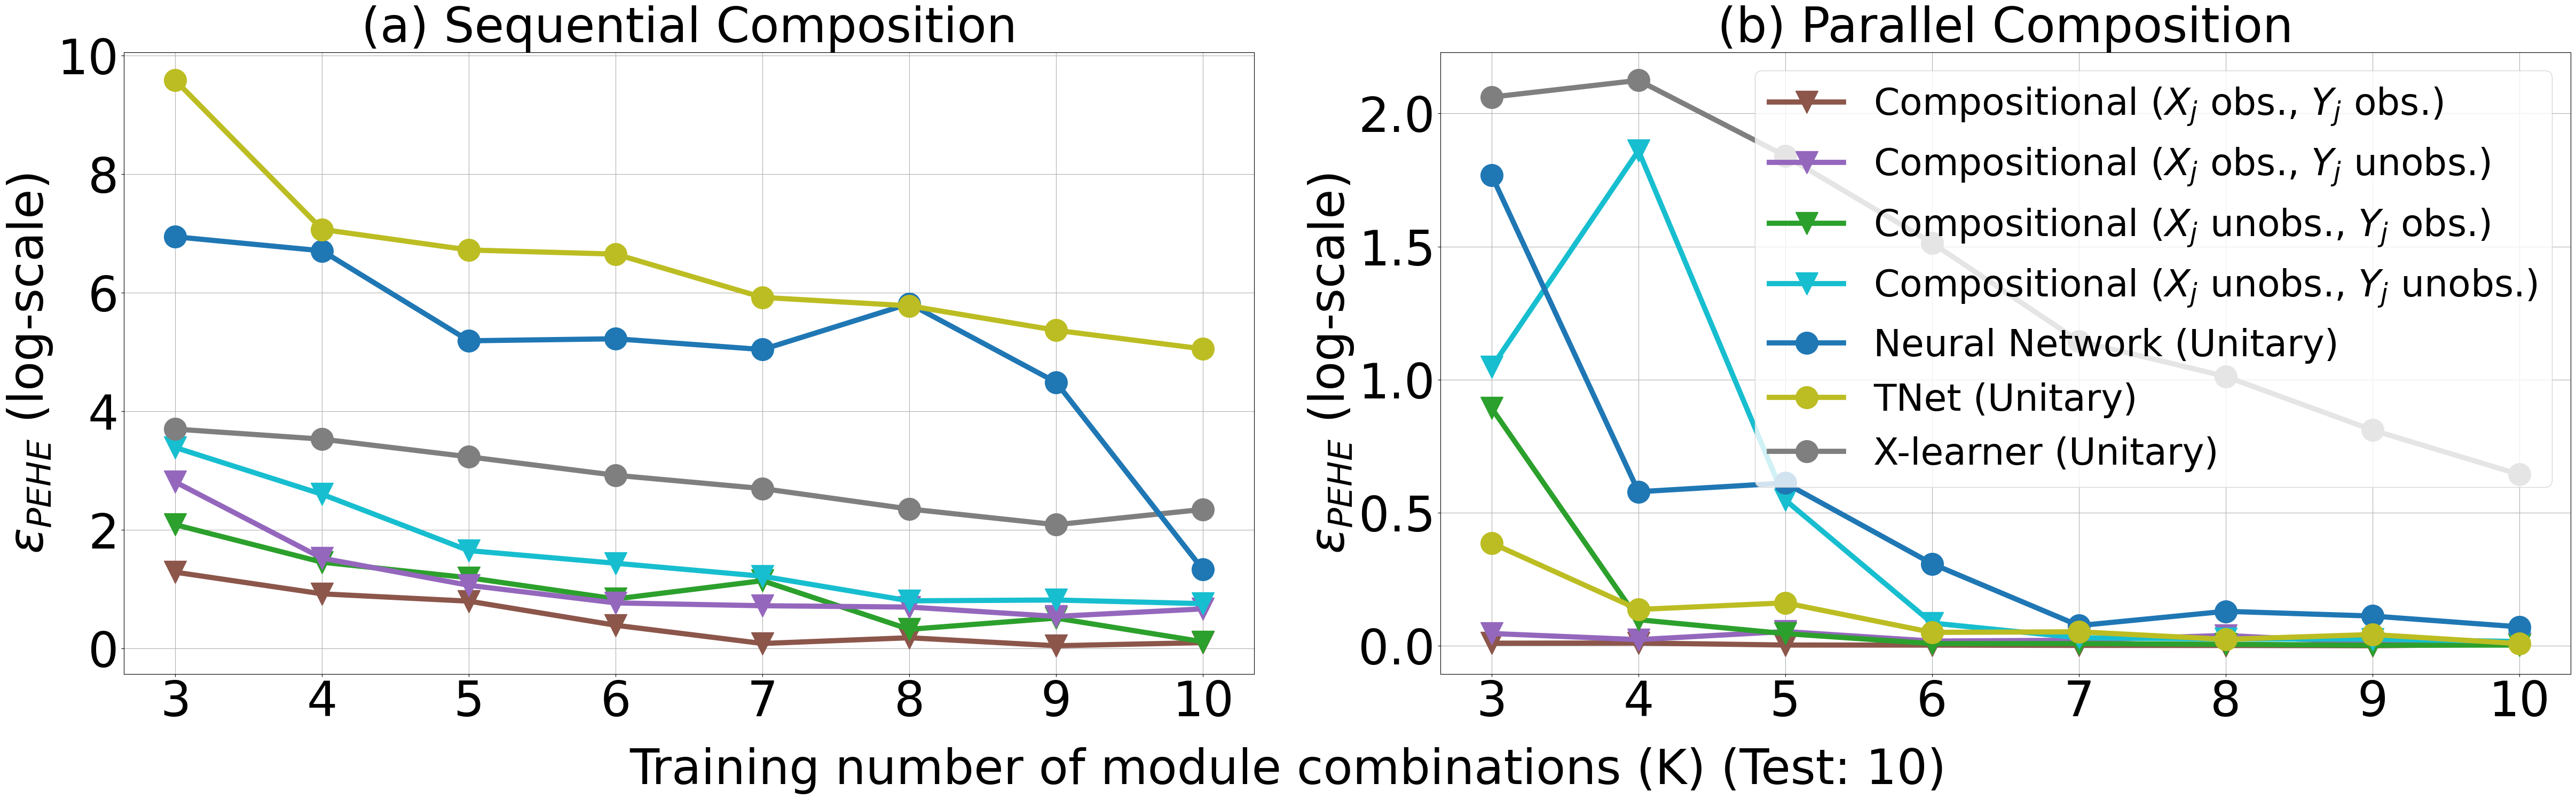

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Plot settings
font_size = 65
plt.rcParams.update({
    'font.size': font_size,
    'legend.fontsize': 50,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size
})
markersize = 30
linewidth = 7

# Colors and styles for both model types
colors = {
    'Baseline': '#1f77b4',
    'MoE': 'green',
    'Catenets': '#bcbd22',
    'Sequential_unknown_cov': '#2ca02c',
    'End_to_End_unknown_cov': '#17becf',
    'Sequential_known_cov': '#8c564b',
    'End_to_End_known_cov': '#9467bd',
    'XLearner': '#7f7f7f'
}

labels = {
    'Sequential_unknown_cov': r'Compositional ($X_j$ unobs., $Y_j$ obs.)',
    'Sequential_known_cov': r'Compositional ($X_j$ obs., $Y_j$ obs.)',
    'End_to_End_unknown_cov': r'Compositional ($X_j$ unobs., $Y_j$ unobs.)',
    'End_to_End_known_cov': r'Compositional ($X_j$ obs., $Y_j$ unobs.)',
    'Baseline': 'Neural Network (Unitary)',
    'XLearner': 'X-learner (Unitary)',
    'Catenets': 'TNet (Unitary)'
}

colors_parallel = {
    'Baseline': '#1f77b4',
    'MoE': '#17becf',
    'MoEknownCov': '#9467bd',
    'Catenets': '#bcbd22',
    'Additive_unknown_cov': '#2ca02c',
    'Additive_known_cov': '#8c564b',
    'XLearner': '#7f7f7f'
}

labels_parallel = {
    'Additive_unknown_cov': r'Compositional ($X_j$ unobs., $Y_j$ obs.)',
    'Additive_known_cov': r'Compositional ($X_j$ obs., $Y_j$ obs.)',
    'MoE': r'Compositional ($X_j$ unobs., $Y_j$ unobs.)',
    'MoEknownCov': r'Compositional ($X_j$ obs., $Y_j$ unobs.)',
    'Catenets': 'TNet (Unitary)',
    'Baseline': 'Neural Network (Unitary)',
    'XLearner': 'X-learner (Unitary)',

}

markers = {
    'Sequential_unknown_cov': 'v', 'Sequential_known_cov': 'v',
    'End_to_End_unknown_cov': 'v', 'End_to_End_known_cov': 'v',
    'Catenets': 'o', 'Baseline': 'o', 'XLearner': 'o'
}

markers_parallel = {
    'Additive_unknown_cov': 'v', 'Additive_known_cov': 'v',
    'MoE': 'v', 'MoEknownCov': 'v',
    'Catenets': 'o', 'Baseline': 'o', 'XLearner': 'o'
}

sequential_order = [
    'Sequential_known_cov',          # Brown triangles
    'Sequential_unknown_cov',        # Green triangles
    'End_to_End_known_cov',         # Purple triangles
    'End_to_End_unknown_cov',       # Cyan triangles
    'XLearner',                     # Gray circles
    'Baseline',                     # Blue circles
    'Catenets'                      # Yellow circles
]

parallel_order = [
    'Additive_known_cov',           # Brown triangles
    'MoEknownCov',                  # Purple triangles
    'Additive_unknown_cov',         # Green triangles
    
    'MoE',   
    'XLearner',                         # Cyan triangles
    'Baseline',                     # Blue circles
    'Catenets',                     # Yellow circles
                        # Gray circles
]

# Create figure with two subplots and space at bottom for legend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 18))

def plot_performance(metric, metric_name, data_type, axis, all_results, is_parallel=False):
    x = list(all_results.keys())[1:] if not is_parallel else list(all_results.keys())[1:]
    x = [int(i) for i in x]
    
    models = parallel_order if is_parallel else sequential_order
    
    for model in models:
        y = [all_results[str(key)][f'{model}_{data_type}'][metric] for key in x]
        y = [0 if i < 0 else i for i in y]
        
        if metric_name == 'PEHE':
            y = [math.log(i+1) for i in y]
        
        x_plot = np.array(x)
        
        label_name = r'{}'.format(labels_parallel[model] if is_parallel else labels[model])
        color = colors_parallel[model] if is_parallel else colors[model]
        marker = markers_parallel[model] if is_parallel else markers[model]
        if model == "MoE":
            print(y)
        print(len(x_plot), len(y))
        axis.plot(x_plot, y, color=color, label=label_name,
                 linestyle='-' if data_type == 'train' else '-',
                 marker=marker, markersize=markersize, linewidth=linewidth)
    
    metric_title = r'$\epsilon_{PEHE}$ (log-scale)' if metric_name == 'PEHE' else r'$R^2 score$'
    axis.set_ylabel(metric_title)
    axis.set_xticks(x_plot)
    axis.grid(True)
    # axis.set_xticklabels([f'{i}' for i in x_plot if i != 10])

# Plot both types of models
plot_performance(0, 'PEHE', 'test', ax1, all_results)
ax1.set_title('(a) Sequential Composition')

plot_performance(0, 'PEHE', 'test', ax2, all_results_parallel, is_parallel=True)
ax2.set_title('(b) Parallel Composition')

# Get unique labels by combining both plots' legends and removing duplicates
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Create dictionary to store unique labels and their handles
unique_labels = {}
for handle, label in zip(handles1 + handles2, labels1 + labels2):
    if label not in unique_labels:
        unique_labels[label] = handle

# Sort labels to group similar items together
sorted_labels = sorted(unique_labels.keys())
sorted_handles = [unique_labels[label] for label in sorted_labels]

# Add common x-axis label
fig.text(0.5, 0.15, 'Training number of module combinations (K) (Test: 10)', 
         ha='center', va='center', fontsize=font_size)

# Adjust subplot spacing to make room for legend and common x-label
plt.subplots_adjust(bottom=0.25)

# Place unified legend below the subplots
ax2.legend(sorted_handles, sorted_labels,
          loc='upper right', ncol=1)

plt.tight_layout()
# Adjust after tight_layout to ensure legend placement is preserved
plt.subplots_adjust(bottom=0.25)

# have last x-axis label as "10 (WID)"


plt.savefig("clear_plots/combined_compositional_x_learner_test_PEHE_x_learner.pdf", bbox_inches='tight', dpi=300)
# plt.show()

In [29]:
all_results_parallel

{'2': {'Baseline_train': [0.022317342380561753, 0.9955252581017041],
  'Baseline_test': [45.681167930685845, -2.7630931909760834],
  'MoE_train': [0.009636600336904754, 0.9980678120831162],
  'MoE_test': [20.034047052497435, -0.6503515445432633],
  'MoEknownCov_train': [0.03777730525892542, 0.9924254560527752],
  'MoEknownCov_test': [0.11864100668522536, 0.9902266692238441],
  'Catenets_train': [0.007793987825304403, 0.9984372653660109],
  'Catenets_test': [2.7368337464711003, 0.7745469106261457],
  'Additive_known_cov_train': [0.0013018093909825663, 0.999738980523483],
  'Additive_known_cov_test': [0.00411769186054034, 0.9996607954895889],
  'Module_known_cov_PEHE_decomposition_test': [0.007275612261215347,
   -0.00315792040067501],
  'Module_PEHE_known_cov_decomposition_train': [0.0068197604392036875,
   -0.0027964213586176914],
  'Additive_unknown_cov_train': [0.00503276541988331, 0.9989909046559118],
  'Additive_unknown_cov_test': [3.743496965621221, 0.6916206704008991],
  'Module_

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


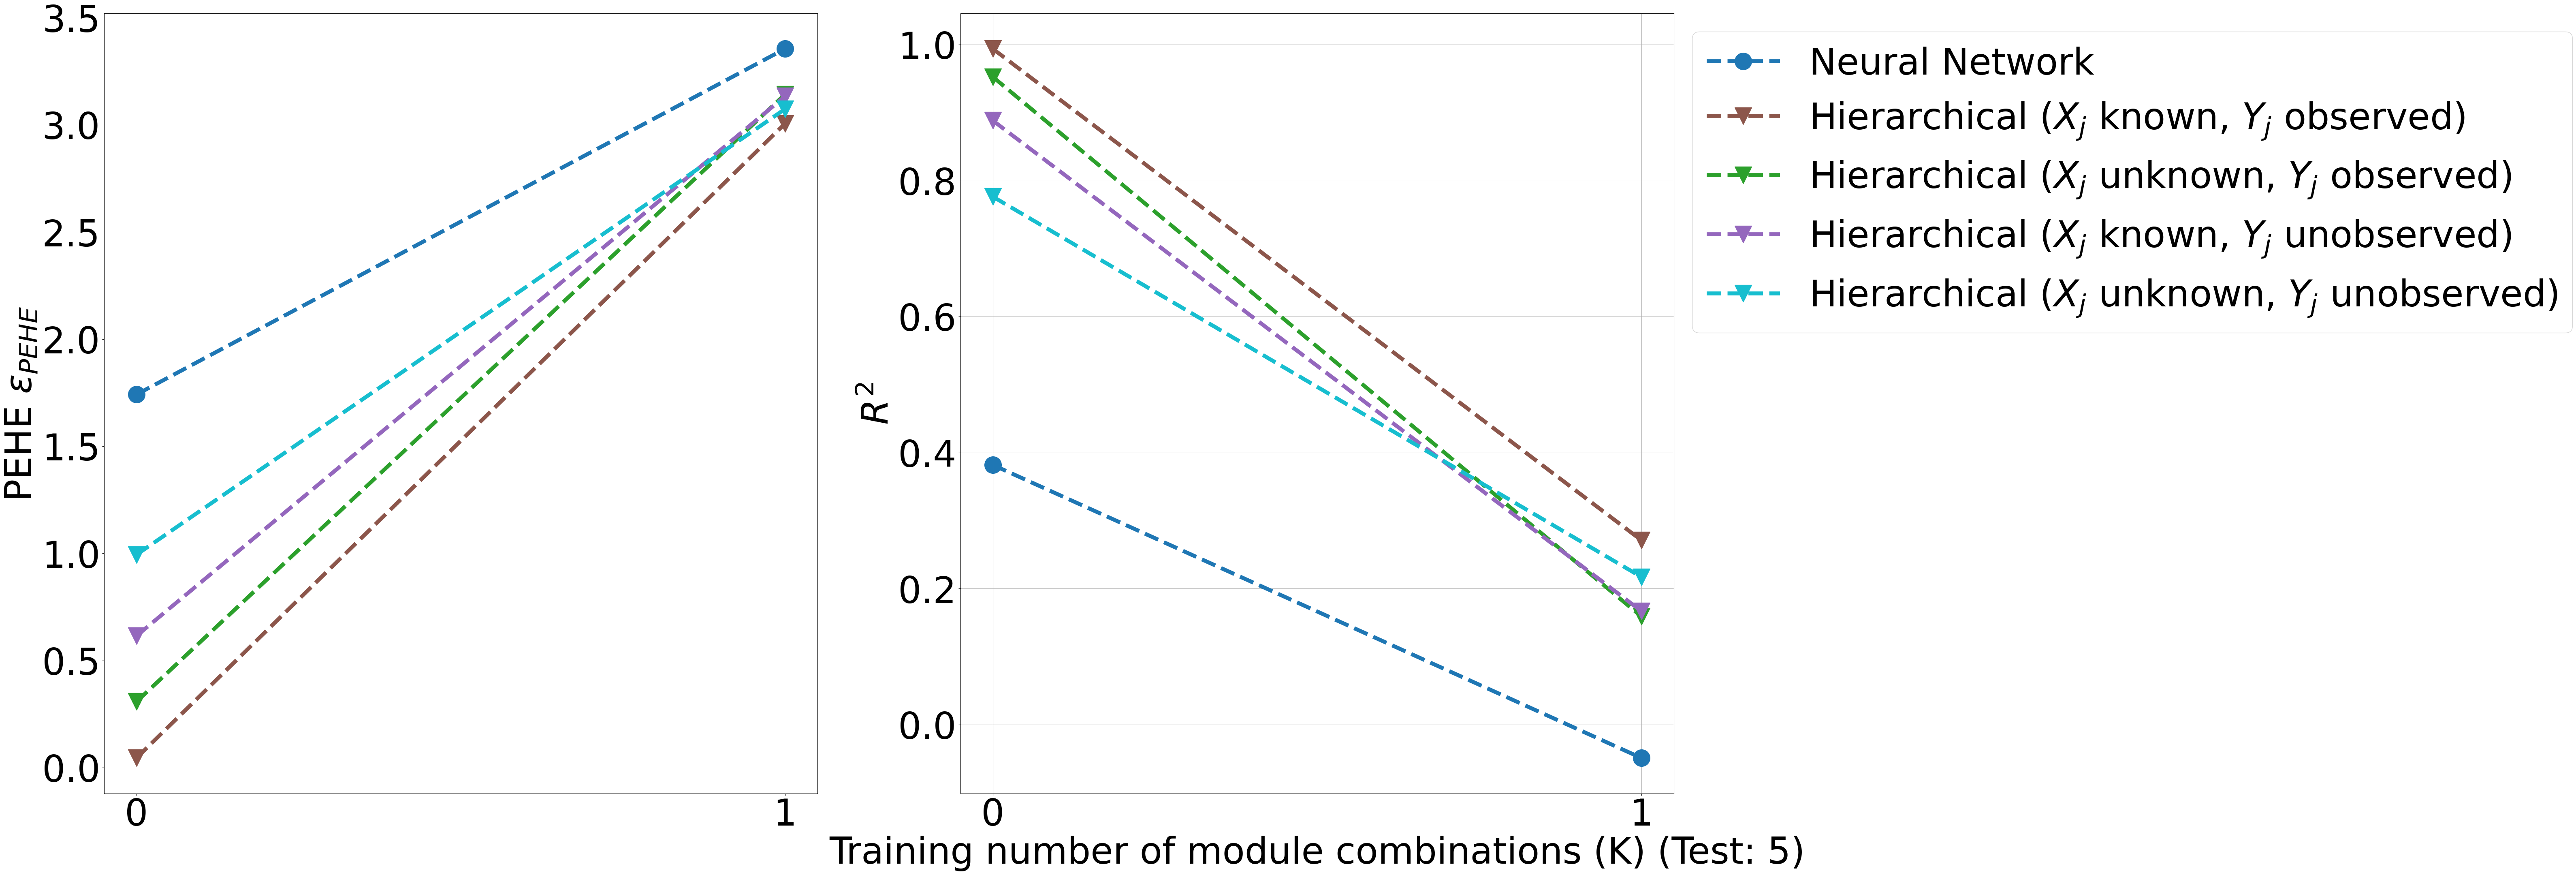

In [57]:
# Colors for each model
from matplotlib import pyplot as plt
import numpy as np
exp = "CG"
args = {}
args["number_of_modules"] = 5
import math
import os

from matplotlib import pyplot as plt
from matplotlib import ticker

# ... (previous code remains the same) ...


font_size = 65
plt.rcParams.update({'font.size': font_size})
plt.rcParams.update({'legend.fontsize': font_size})
plt.rcParams.update({'axes.labelsize': font_size})
plt.rcParams.update({'axes.titlesize': font_size})
markersize = 30


# "neural_network": '#1f77b4',
#                 "recursive_single_outcome": '#ff7f0e',
#                 "recursive_all_outcomes": '#2ca02c',
#                 "modular_single_outcome": '#17becf',
#                 "modular_all_outcomes": '#9467bd',
#                 "random_forest_additive": '#8c564b',
#                 "neural_network_additive": '#8c564b',
#                 "x_learner": '#7f7f7f',
#                 "s_learner": '#bcbd22',
#                 "t_learner":  '#17becf',
#                 "random_forest": '#e377c2',
#                 "non_param_DML": '#d62728',
#                 "snet1": '#8c564b',
#                 "snet2": '#d62728',
#                 "tnet": '#bcbd22'

colors = {
    'Baseline': '#1f77b4',
    'MoE': 'green',
    'Catenets': '#bcbd22',
    'Sequential_unknown_cov': '#2ca02c',
    'End_to_End_unknown_cov': '#17becf',
    'Sequential_known_cov': '#8c564b',
    'End_to_End_known_cov': '#9467bd'
}
linewidth = 7


labels = {'Sequential_unknown_cov': r'Hierarchical ($X_j$ unknown, $Y_j$ observed)', 'Sequential_known_cov': r'Hierarchical ($X_j$ known, $Y_j$ observed)', 'End_to_End_unknown_cov': r'Hierarchical ($X_j$ unknown, $Y_j$ unobserved)', 'End_to_End_known_cov': r'Hierarchical ($X_j$ known, $Y_j$ unobserved)', 'Catenets': 'TNet', 'Baseline': 'Neural Network'}
markers = {'Sequential_unknown_cov': 'v', 'Sequential_known_cov': 'v', 'End_to_End_unknown_cov': 'v', 'End_to_End_known_cov': 'v', 'Catenets': 'o', 'Baseline': 'o'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 25))
# Function to plot performance
def plot_performance(metric, metric_name, data_type, axis):
    # fig1, ax1 = plt.subplots(figsize=(25, 20))
    
    x = list(all_results.keys())
    # convert string to float
    x = [int(i) for i in x]
    # remove key 5
    # x = [i for i in x if i != 5]
   
    
    for model in ['Baseline',  'Sequential_known_cov', 'Sequential_unknown_cov', 'End_to_End_known_cov', 'End_to_End_unknown_cov']:
        y = [all_results[str(key)][f'{model}_{data_type}'][metric] for key in x]
        # log scale for PEHE
        if metric_name == 'PEHE':
            y = [math.log(i+1) for i in y]
        # if exp == "noise":
        x_plot = np.array(x)
        # else:
        #     x_plot = 1-np.array(x)
        #     print(x_plot)
        #     x_plot = [i*5 for i in x_plot]
        print(x_plot)


        label_name = r'{}'.format(labels[model])
        axis.plot(x_plot, y, color=colors[model], label=label_name,
                 linestyle='-' if data_type == 'train' else '--', marker=markers[model], markersize=markersize, linewidth=linewidth)

        
    
    plt.xlabel('Training number of module combinations (K) (Test: 5)')
    if metric_name == 'PEHE':
        metric_title = r'PEHE $\epsilon_{PEHE}$'
    elif metric_name == 'R^2':
        metric_title = r'$R^2$'
    axis.set_ylabel(metric_title)
    # y-axis in log scale
    # plt.yscale('log')
    
    # set x-axis ticks as x_plot
    axis.set_xticks(x_plot)
    
    # plt.title(f'{metric_title} Performance ({data_type.capitalize()})')
    # legend outside plot
    
# Plot PEHE for train and test
# plot_performance(0, 'PEHE', 'train')
plot_performance(0, 'PEHE', 'test', ax1)

# # Plot R^2 for train and test
# plot_performance(1, 'R^2', 'train')
plot_performance(1, 'R^2', 'test', ax2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=font_size)
    
    
plt.grid(True)

plot_dir = "clear_plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plt.savefig("clear_plots/prior_knowledge.pdf", bbox_inches='tight')



In [18]:
all_results = "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/systematic_True/all_results_uniform_parallel_covariates_shared_False_use_subset_features_False_combined_results_sequential_exp_noise_number_of_modules_10_rerun.json"

with open(all_results) as f:
    all_results = json.load(f)

all_results.keys()

dict_keys(['0', '1'])

[0 1]
[0 1]


KeyError: 'Sequential_unknown_cov_train'

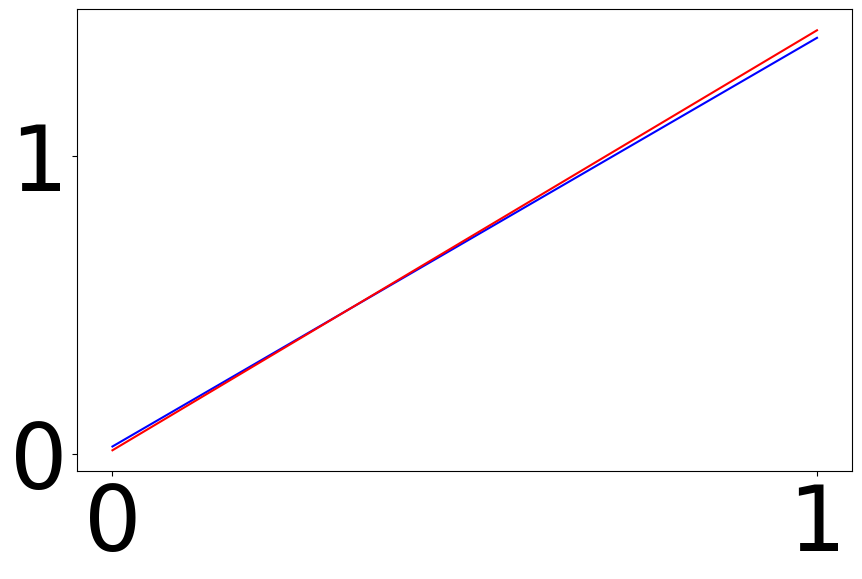

In [19]:
# Colors for each model
from matplotlib import pyplot as plt
import numpy as np
exp = "CG"
args = {}
args["number_of_modules"] = 5
import math
colors = {
    'Baseline': 'blue',
    'MoE': 'green',
    'Catenets': 'red',
    'Sequential_unknown_cov': 'purple',
    'End_to_End_unknown_cov': 'orange',
    'Sequential_known_cov': 'black',
    'End_to_End_known_cov': 'brown'
}

# Function to plot performance
def plot_performance(metric, metric_name, data_type):
    plt.figure(figsize=(10, 6))
    x = list(all_results.keys())
    # convert string to float
    x = [int(i) for i in x]
    # remove key 5
    # x = [i for i in x if i != 5]
   
    
    for model in ['Baseline', 'Catenets', 'Sequential_unknown_cov', 'End_to_End_unknown_cov', 'Sequential_known_cov', 'End_to_End_known_cov']:
        y = [all_results[str(key)][f'{model}_{data_type}'][metric] for key in x]
        # log scale for PEHE
        if metric_name == 'PEHE':
            y = [math.log(i+1) for i in y]
        # if exp == "noise":
        x_plot = np.array(x)
        # else:
        #     x_plot = 1-np.array(x)
        #     print(x_plot)
        #     x_plot = [i*5 for i in x_plot]
        print(x_plot)
        plt.plot(x_plot, y, color=colors[model], label=model, 
                 linestyle='-' if data_type == 'train' else '--')
    
    plt.xlabel('Number of module combinations on which model is trained')
    plt.ylabel(metric_name)
    # y-axis in log scale
    # plt.yscale('log')
    plt.title(f'{metric_name} Performance ({data_type.capitalize()})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot PEHE for train and test
plot_performance(0, 'PEHE', 'train')
plot_performance(0, 'PEHE', 'test')

# Plot R^2 for train and test
plot_performance(1, 'R^2', 'train')
plot_performance(1, 'R^2', 'test')

In [9]:
# divide query output by number of non-zero modules
# divide query output by number of non-zero modules
num_modules = [col for col in train_df.columns if col.startswith('num_module_')]
train_df['query_output'] = train_df['query_output'] / train_df[num_modules].sum(axis=1)
test_df['query_output'] = test_df['query_output'] / test_df[num_modules].sum(axis=1)

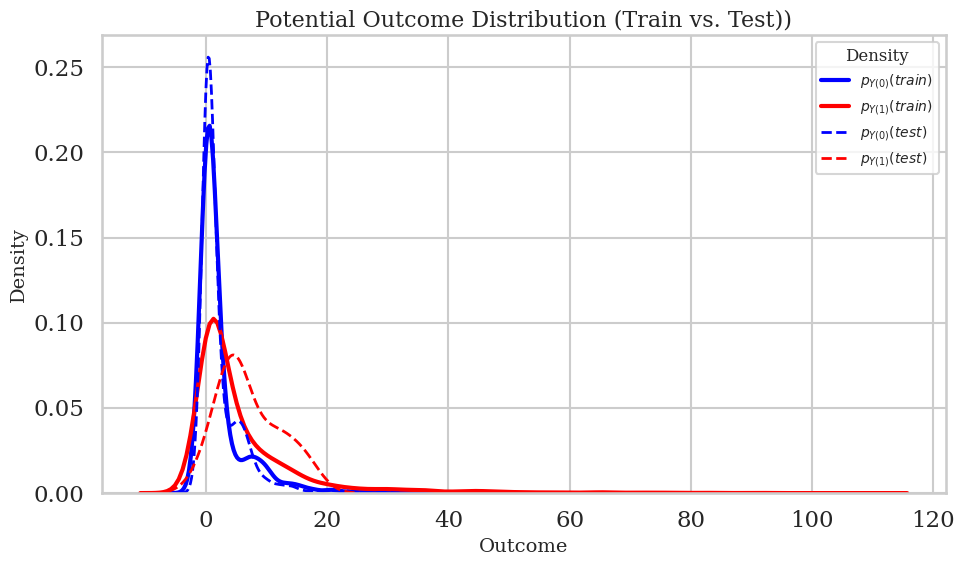

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and enable LaTeX
plt.rcParams.update({
    "font.family": "serif",
})

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

# Plot density for train data (bold lines)
for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_{Y(0)}}(train)$'
    else:
        label = r'${p_{Y(1)}}(train)$'
    sns.kdeplot(data=train_df[train_df['treatment_id'] == treatment], 
                x='query_output', color=colors[treatment], 
                linestyle='-', linewidth=3,  # Bold line
                label=label)

# Plot density for test data (dashed lines)

for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_{Y(0)}}(test)$'
    else:
        label = r'${p_{Y(1)}}(test)$'
    sns.kdeplot(data=test_df[test_df['treatment_id'] == treatment], 
                x='query_output', color=colors[treatment], 
                linestyle='--', linewidth=2,  # Dashed line
                label=label)

# Set title and labels
plt.title("Potential Outcome Distribution (Train vs. Test))", fontsize=16)
plt.xlabel("Outcome", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add legend
plt.legend(title='Density', title_fontsize=12, fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and enable LaTeX
plt.rcParams.update({
    "font.family": "serif",
})

# Create the figure
plt.figure(figsize=(10, 6))

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

# Plot density for train data (bold lines)
for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_0}(train)$'
    else:
        label = r'${p_1}(train)$'
    sns.kdeplot(data=train_df[train_df['treatment_id'] == treatment], 
                x='feature_0', color=colors[treatment], 
                linestyle='-', linewidth=3,  # Bold line
                label=label)

# Plot density for test data (dashed lines)

for treatment in [0, 1]:
    if treatment == 0:
        label = r'${p_0}(test)$'
    else:
        label = r'${p_1}(test)$'
    sns.kdeplot(data=test_df[test_df['treatment_id'] == treatment], 
                x='feature_0', color=colors[treatment], 
                linestyle='--', linewidth=2,  # Dashed line
                label=label)

# Set title and labels
plt.title("Covariate Distribution (Train vs. Test))", fontsize=16)
plt.xlabel(r'X', fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add legend
plt.legend(title='Density', title_fontsize=12, fontsize=10)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

ValueError: Could not interpret value `feature_0` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [28]:
train_df

,feature_0,query_id,treatment_id,tree_depth,query_output,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,num_module_9,num_module_10,estimated_effect
0,3.287332,0.0,0.0,2.0,7.450842,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.721162
1,1.386121,1.0,1.0,2.0,2.614076,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.935652
2,1.449184,2.0,0.0,2.0,3.555470,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.946573
3,1.830773,3.0,1.0,2.0,3.415209,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.963807
4,3.214268,4.0,0.0,2.0,7.283298,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.725684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1.817987,1975.0,1.0,2.0,6.256585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.788571
1976,1.355247,1976.0,1.0,2.0,5.394947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.306489
1977,0.834129,1977.0,1.0,2.0,4.640085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.143926
1978,1.245059,1978.0,1.0,2.0,5.219637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.202561


In [29]:
test_df

,feature_0,query_id,treatment_id,tree_depth,query_output,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,num_module_9,num_module_10,estimated_effect
1980,2.024449,1980.0,1.0,3.0,8.371116,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.675675
1981,1.386121,1981.0,0.0,3.0,5.545832,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.567783
1982,1.449184,1982.0,1.0,3.0,7.034041,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570514
1983,1.830773,1983.0,1.0,3.0,7.928381,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625453
1984,3.214268,1984.0,1.0,3.0,10.883003,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.136444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17339,1.158450,17339.0,0.0,10.0,28.811296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.616271
17340,2.058481,17340.0,0.0,10.0,29.285012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.825939
17341,2.563185,17341.0,0.0,10.0,29.983296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.333226
17342,1.859517,17342.0,0.0,10.0,29.078769,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.001904


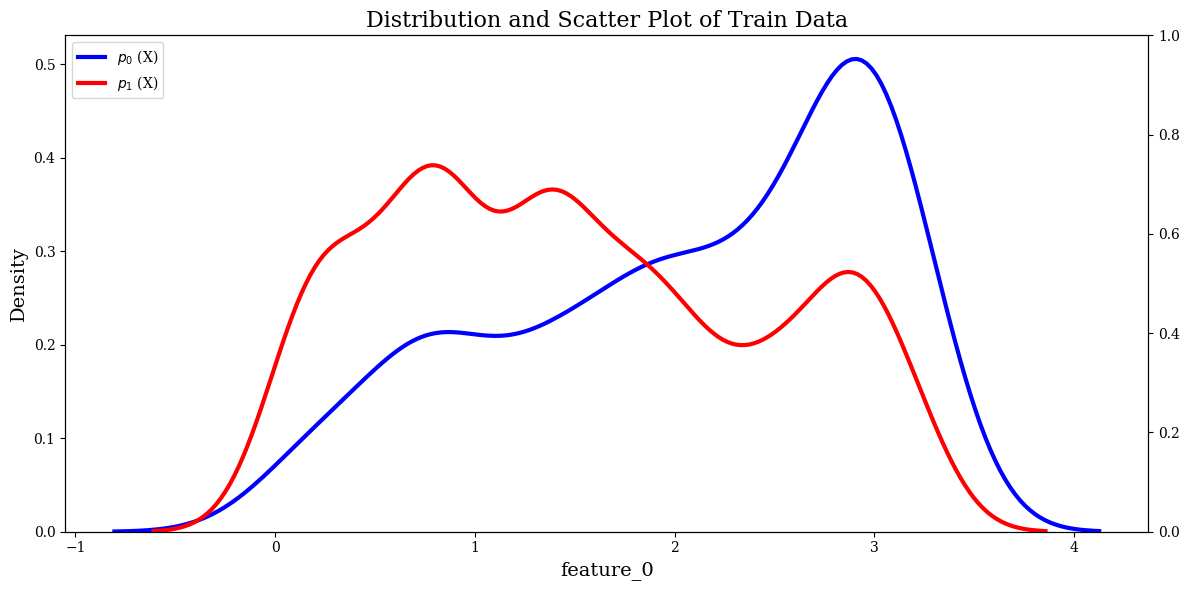

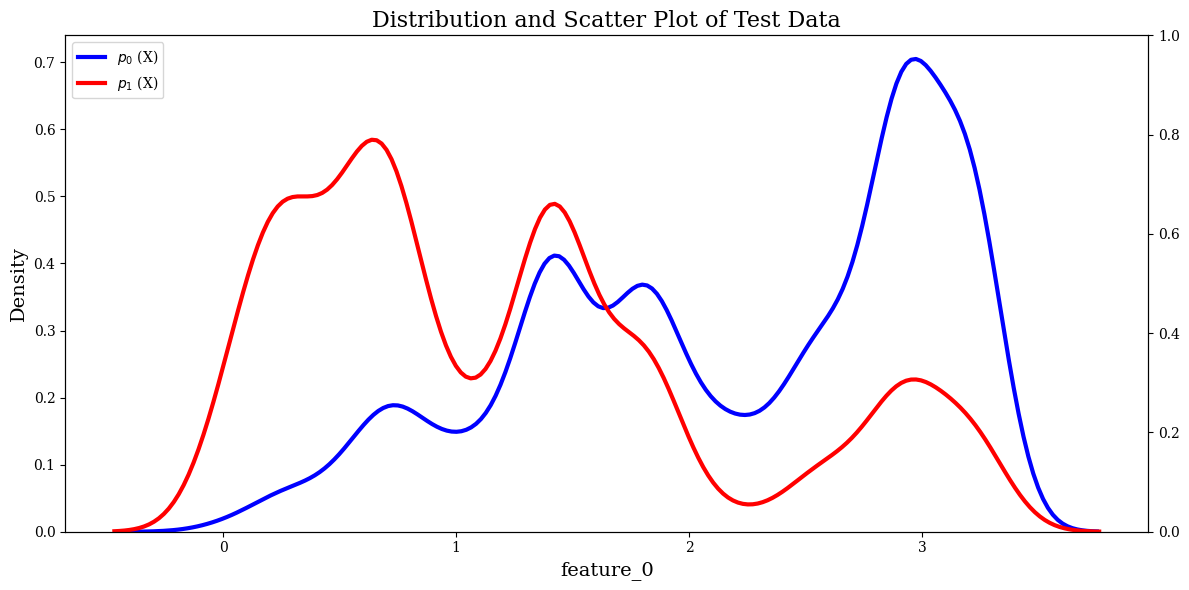

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.rcParams.update({
    "font.family": "serif",
})

# Define colors for treatments
colors = ['blue', 'red']  # blue for p_0, red for p_1

def create_density_scatter_plot(data, title):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    for treatment in [0, 1]:
        subset = data[data['treatment_id'] == treatment]
        
        # Density plot for feature_0
        sns.kdeplot(data=subset, x='feature_0', ax=ax1, color=colors[treatment], 
                    linestyle='-', linewidth=3, 
                    label=r'$p_{}$ (X)'.format(treatment))
        
        # # Scatter plot
        # ax2.scatter(subset['feature_0'], subset['query_output'], 
        #             color=colors[treatment], alpha=0.3, s=10,
        #             label=r'$p_{}$ (query_output)'.format(treatment))
    
    ax1.set_xlabel("feature_0", fontsize=14)
    ax1.set_ylabel("Density", fontsize=14)
    # ax2.set_ylabel("query_output", fontsize=14)
    
    ax1.set_title(title, fontsize=16)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()

# Create plot for train data
create_density_scatter_plot(train_df, "Distribution and Scatter Plot of Train Data")
plt.show()

# Create plot for test data
create_density_scatter_plot(test_df, "Distribution and Scatter Plot of Test Data")
plt.show()

<Axes: xlabel='query_output', ylabel='Count'>

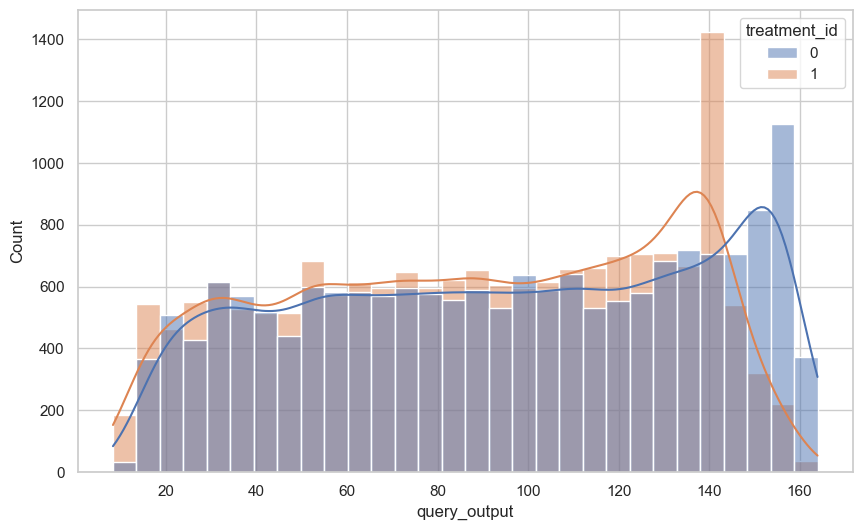

In [17]:
Y_1 = np.mean(data[data['treatment_id'] == 1]['query_output'])
Y_0 = np.mean(data[data['treatment_id'] == 0]['query_output'])

# plot the distribution of the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data, x='query_output', hue='treatment_id', bins=30, kde=True)

In [9]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 0.7511988074220146, E[Y_0] = 1.2141302990399152
module_2 E[Y_1] = 0.8987803679252591, E[Y_0] = 0.6763471384742122
module_3 E[Y_1] = 0.7975753967033942, E[Y_0] = 0.9289424348409615
Sum of E[Y_1] = 2.447554572050668, E[Y_0] = 2.819419872355089


In [10]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 0.7511988074220146, E[Y_0] = 1.2141302990399152
module_2 E[Y_1] = 0.8987803679252591, E[Y_0] = 0.6763471384742122
module_3 E[Y_1] = 0.7975753967033942, E[Y_0] = 0.9289424348409615
Sum of E[Y_1] = 2.447554572050668, E[Y_0] = 2.819419872355089


In [12]:
for module_file, module_csv in module_csvs_test.items():
    module_id = int(module_file.split("_")[-1])
    print(f"Module {module_id}")
    pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
    print(f"PEHE: {pehe_score}")
    print(f"R2 Score: {r2_score(module_csv['ground_truth_effect'], module_csv['estimated_effect'])}")
    print("\n")

Module 1
PEHE: 8.43045680913006e-06
R2 Score: 0.9992116406238679


Module 3
PEHE: 3.409530403483242e-06
R2 Score: 0.9998127937246573


Module 2
PEHE: 2.948808966524245e-06
R2 Score: 0.9999532899051761




In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X = data[["feature_0"]].values
# T = data[treatment].values
# Y = data[outcome].values
# Y_module = data[[f"module_{i}_output" for i in range(1, args.num_modules + 1)]].values
# X_T = np.concatenate([X, T.reshape(-1, 1)], axis=1)
# X_T = torch.tensor(X_T, dtype=torch.float32).to(device)
# expert_outputs = torch.stack([expert(X_T) for expert in model.experts], dim=1)
# gate_outputs = model.gate(X_T)
# expert_gate_multiplication = expert_outputs.squeeze(-1) * gate_outputs
# print(expert_outputs.shape, Y_module.shape, expert_gate_multiplication.shape)


In [13]:
# for i in range(6):
#     data["expert_output_" + str(i)] = expert_gate_multiplication[:, i].detach().cpu().numpy()

covariates

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

In [6]:
# data["final_output"] = final_output.squeeze(0).detach().cpu().numpy()

# # scatter plot for final output and query output
# plt.figure(figsize=(10, 10))
# sns.scatterplot(x="query_output", y="final_output", data=data)
# plt.xlabel("Query Output")
# plt.ylabel("Final Output")
# plt.title("Final Output vs Query Output")
# plt.show()

<AxesSubplot:xlabel='feature_0', ylabel='query_output'>

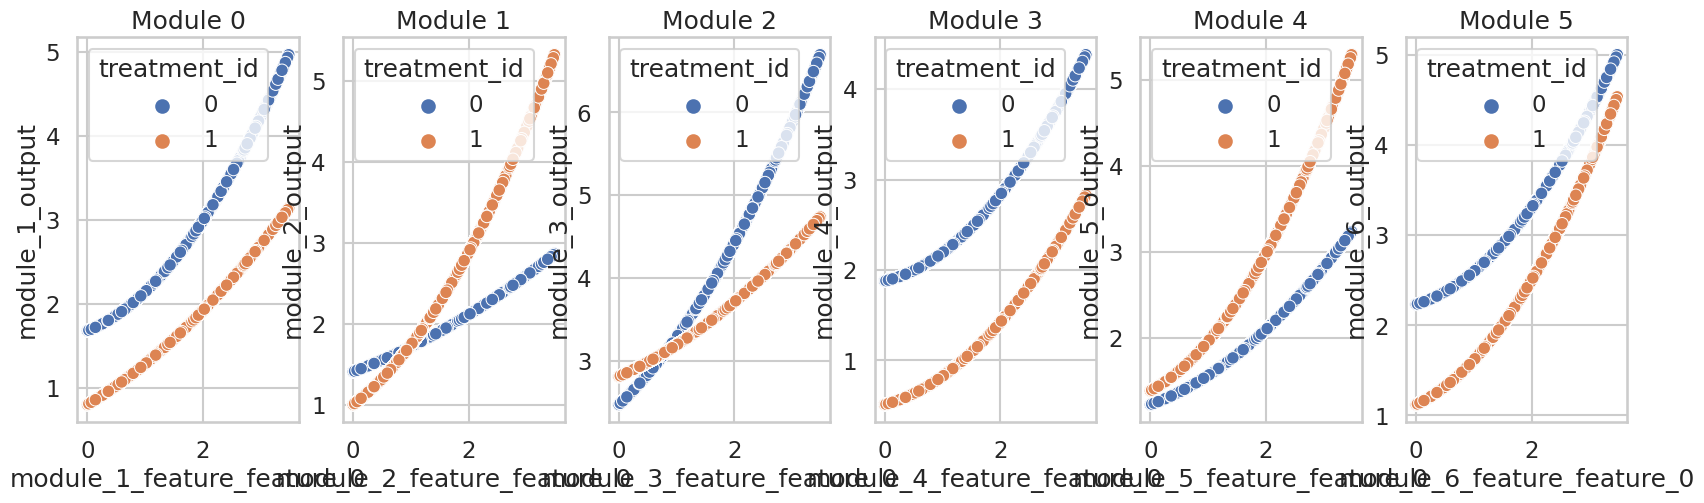

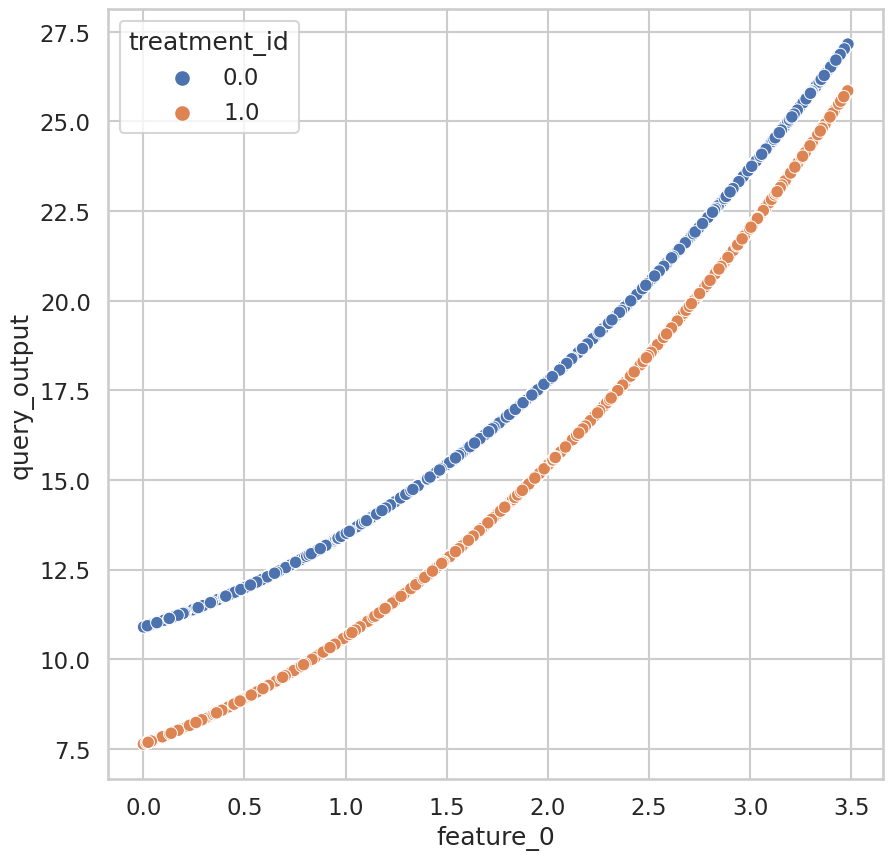

In [ ]:
# plot distribution of the covariates for train df with treatment id
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data=train_df, x="feature_0", hue="treatment_id", label="Train", color="blue", ax=ax[0])
ax[0].set_title("Train Distribution")
sns.kdeplot(data=test_df, x="feature_0", hue="treatment_id", label="Test", color="red", ax=ax[1])
ax[1].set_title("Test Distribution")


plt.title("Train Distribution")
plt.show()

In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")


plt.title("Train Distribution")
plt.show()





In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





# Results Analysis

In [22]:
# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

2024-09-22 03:07:47.829116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_uniform_quadratic_parallel_covariates_shared_False_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs
Done!


In [23]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [24]:
combined_df_test

,ground_truth_effect,estimated_effect
0,-0.293698,-0.311285
1,-0.641127,-0.642452
2,-0.612727,-0.604818
3,0.239012,0.246677
4,-0.717167,-0.693429
...,...,...
162,-0.719175,-0.764137
163,0.595639,0.640840
164,1.285423,1.451030
165,-0.269334,-0.208952


In [16]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
# hl_filepath = f"{results_csv_folder}/combined_df_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}.csv"
hl_filepath = f"{results_csv_folder}/additive_combined_test_df.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns

pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


KeyError: 'ground_truth_effect_baseline'

# Expectation Analysis for Different Composition Models 

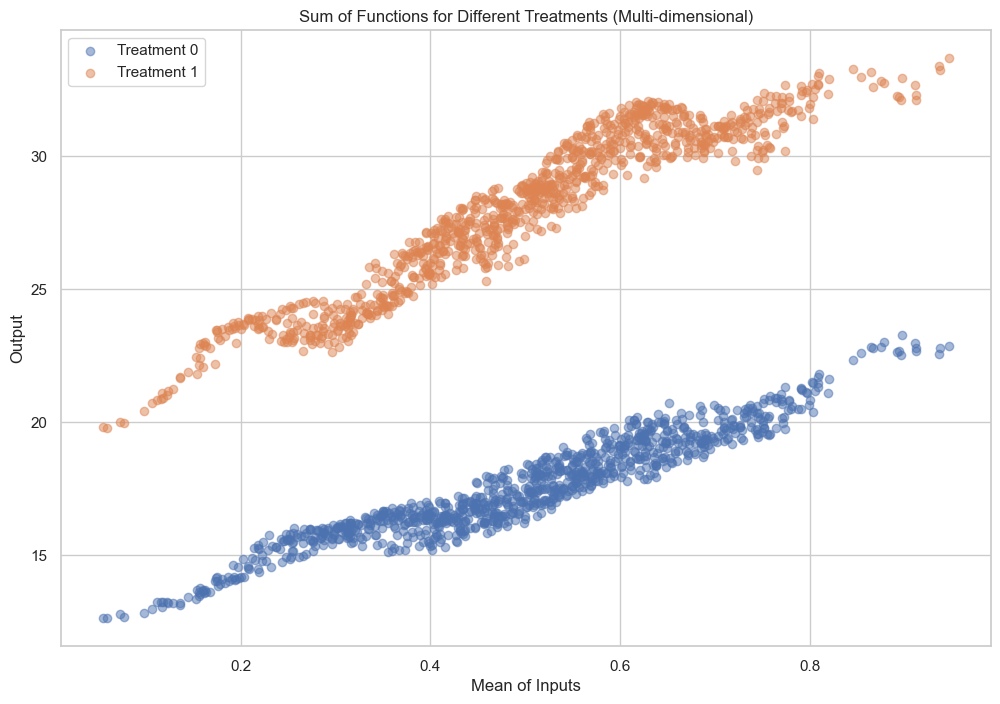

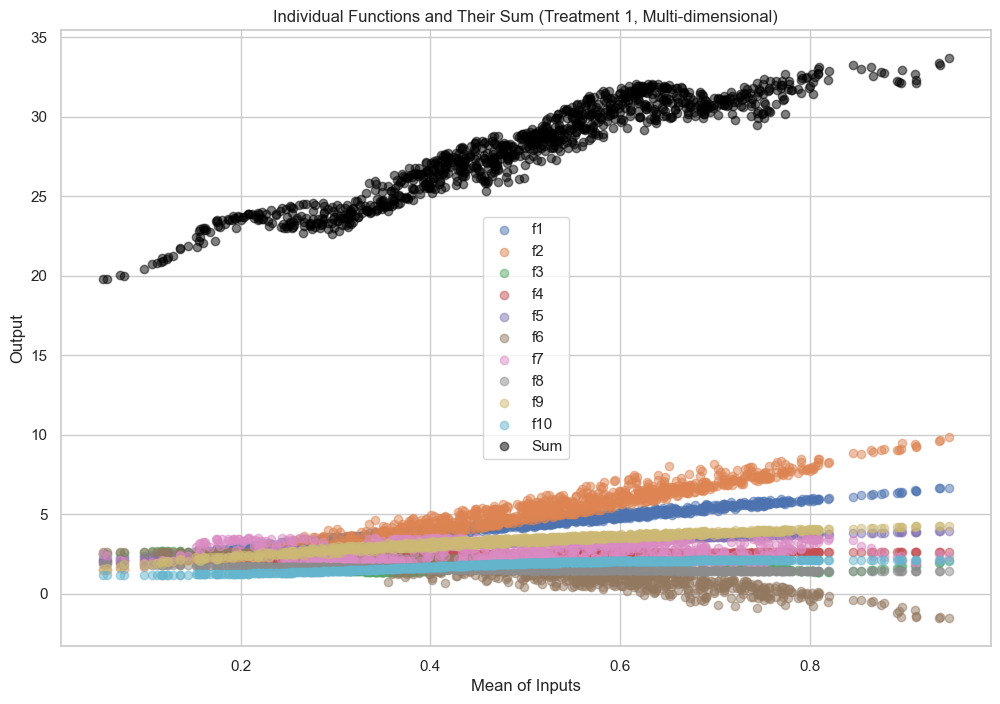

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def f1(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return np.dot(X, w[:Mj]) + w[-1]

def f2(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return np.dot(X**2, w[:Mj]) + np.dot(X, w[Mj:2*Mj]) + w[-1]

def f3(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (np.sin(np.pi * np.dot(X, w[1:Mj+1])) / 2 + 0.5) + w[-1]

def f4(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] / (1 + np.exp(-np.dot(X, w[1:Mj+1]))) + w[-1]

def f5(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.sqrt(np.dot(X, w[1:Mj+1])) + w[-1]

def f6(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (1 - np.dot(X**3, w[1:Mj+1])) + w[-1]

def f7(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (0.5 * np.cos(2 * np.pi * np.dot(X, w[1:Mj+1])) + 0.5) + w[-1]

def f8(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.exp(-np.dot(X, w[1:Mj+1])) / (1 + np.exp(-np.dot(X, w[1:Mj+1]))) + w[-1]

def f9(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * np.log(np.dot(X, w[1:Mj+1]) + 1) / np.log(2) + w[-1]

def f10(*inputs, w):
    X = np.array(inputs)
    Mj = len(X)
    return w[0] * (0.5 * np.tanh(np.dot(X, w[1:Mj+1]) - 2) + 0.5) + w[-1]

def sample_weights(t, input_dim):
    np.random.seed(42)  # for reproducibility
    if t == 0:
        base = 0.5
        scale = 1.0
    else:
        base = 1.0
        scale = 1.0
    
    weights = []
    for _ in range(10):  # 10 functions
        w = np.random.uniform(base, base + scale, 2 * input_dim + 2)
        weights.append(w)
    
    return weights

def sum_function(inputs, weights):
    return sum(f(*inputs, w=w) for f, w in zip([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10], weights))

# Generate multi-dimensional inputs
input_dim = 3  # Change this to adjust the number of input dimensions
num_samples = 1000
inputs = np.random.rand(num_samples, input_dim)

# Plot functions for both treatments
plt.figure(figsize=(12, 8))

for t in [0, 1]:
    weights = sample_weights(t, input_dim)
    y = [sum_function(input_row, weights) for input_row in inputs]
    plt.scatter(np.mean(inputs, axis=1), y, alpha=0.5, label=f'Treatment {t}')

plt.xlabel('Mean of Inputs')
plt.ylabel('Output')
plt.title('Sum of Functions for Different Treatments (Multi-dimensional)')
plt.legend()
plt.grid(True)
plt.show()

# Plot individual functions for a specific treatment
t = 1  # Change this to 0 or 1 to see different treatments
weights = sample_weights(t, input_dim)

plt.figure(figsize=(12, 8))
for i, func in enumerate([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]):
    y = [func(*input_row, w=weights[i]) for input_row in inputs]
    plt.scatter(np.mean(inputs, axis=1), y, alpha=0.5, label=f'f{i+1}')

y_sum = [sum_function(input_row, weights) for input_row in inputs]
plt.scatter(np.mean(inputs, axis=1), y_sum, alpha=0.5, label='Sum', color='black')
plt.xlabel('Mean of Inputs')
plt.ylabel('Output')
plt.title(f'Individual Functions and Their Sum (Treatment {t}, Multi-dimensional)')
plt.legend()
plt.grid(True)
plt.show()

# Data Analysis

# Data baseline model 

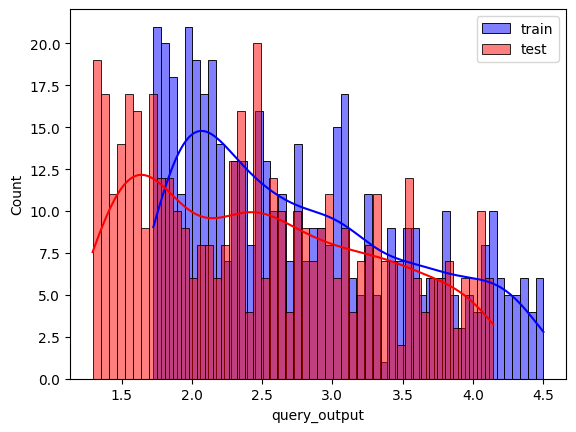

In [3]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

NameError: name 'baseline_combined_df' is not defined

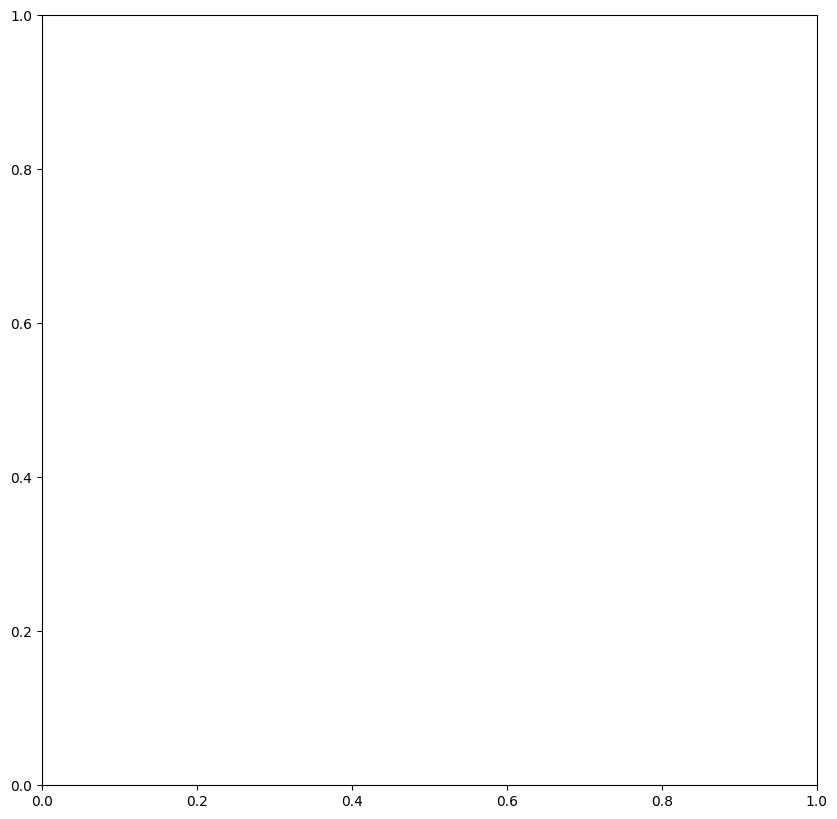

In [4]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

